# Visualize model generalizability on Plates 1 and 2

In this notebook, we will be looking at the predicted probabilities of each cell that are labeled for either healthy or failing cell type in Plates 1 and 2. 

We generate a facet ridge plot to look at the distribution of probabilities for each binary class across dose. 
Bar charts are also generated to look at the counts.

## Import libraries

In [1]:
suppressPackageStartupMessages(suppressWarnings(library(ggplot2))) # plotting
suppressPackageStartupMessages(suppressWarnings(library(dplyr))) # data manipulation
suppressPackageStartupMessages(suppressWarnings(library(ggridges))) # ridge line plots
suppressPackageStartupMessages(suppressWarnings(library(RColorBrewer))) # color palettes

## Load in predicted probabilities for Plates 1 and 2

In [2]:
# load in the probabilities
combined_probabilities_path <- file.path(
    paste0(
        "./prob_data/combined_plates_1_2_predicted_proba.csv"
    )
)
# read in the data from the parquet file
combined_probabilities_df <- read.csv(
    combined_probabilities_path
)
dim(combined_probabilities_df)
head(combined_probabilities_df,2)

[1] 81290    23

,Failing_probas,Healthy_probas,predicted_label,Metadata_WellRow,Metadata_WellCol,Metadata_heart_number,Metadata_treatment,Metadata_dose,Metadata_dose_unit,Metadata_Nuclei_Location_Center_X,⋯,Metadata_Image_Count_Cells,Metadata_ImageNumber,Metadata_Plate,Metadata_Well,Metadata_Cells_Number_Object_Number,Metadata_Cytoplasm_Parent_Cells,Metadata_Cytoplasm_Parent_Nuclei,Metadata_Nuclei_Number_Object_Number,Metadata_Site,model_type
,<dbl>,<dbl>,<chr>,<chr>,<int>,<int>,<chr>,<dbl>,<chr>,<dbl>,⋯,<int>,<int>,<chr>,<chr>,<int>,<int>,<int>,<int>,<chr>,<chr>
1,0.7257504,0.2742496,Failing,A,1,3,drug_x,5,uM,220.49110,⋯,35,1,localhost220512140003_KK22-05-198,A01,2,2,4,4,f00,shuffled
2,0.7692158,0.2307842,Failing,A,1,3,drug_x,5,uM,77.76578,⋯,35,1,localhost220512140003_KK22-05-198,A01,3,3,6,6,f00,shuffled


## Mutate heart number and dose to be characters instead of int for plotting

In [3]:
# Assuming df is your dataframe
combined_probabilities_df <- combined_probabilities_df %>%
  mutate(Metadata_heart_number = as.character(Metadata_heart_number),
         Metadata_dose = as.character(Metadata_dose))

dim(combined_probabilities_df)
head(combined_probabilities_df,2)

[1] 81290    23

,Failing_probas,Healthy_probas,predicted_label,Metadata_WellRow,Metadata_WellCol,Metadata_heart_number,Metadata_treatment,Metadata_dose,Metadata_dose_unit,Metadata_Nuclei_Location_Center_X,⋯,Metadata_Image_Count_Cells,Metadata_ImageNumber,Metadata_Plate,Metadata_Well,Metadata_Cells_Number_Object_Number,Metadata_Cytoplasm_Parent_Cells,Metadata_Cytoplasm_Parent_Nuclei,Metadata_Nuclei_Number_Object_Number,Metadata_Site,model_type
,<dbl>,<dbl>,<chr>,<chr>,<int>,<chr>,<chr>,<chr>,<chr>,<dbl>,⋯,<int>,<int>,<chr>,<chr>,<int>,<int>,<int>,<int>,<chr>,<chr>
1,0.7257504,0.2742496,Failing,A,1,3,drug_x,5,uM,220.49110,⋯,35,1,localhost220512140003_KK22-05-198,A01,2,2,4,4,f00,shuffled
2,0.7692158,0.2307842,Failing,A,1,3,drug_x,5,uM,77.76578,⋯,35,1,localhost220512140003_KK22-05-198,A01,3,3,6,6,f00,shuffled


## Generate a ridge plot with healthy probabilities faceted by dose

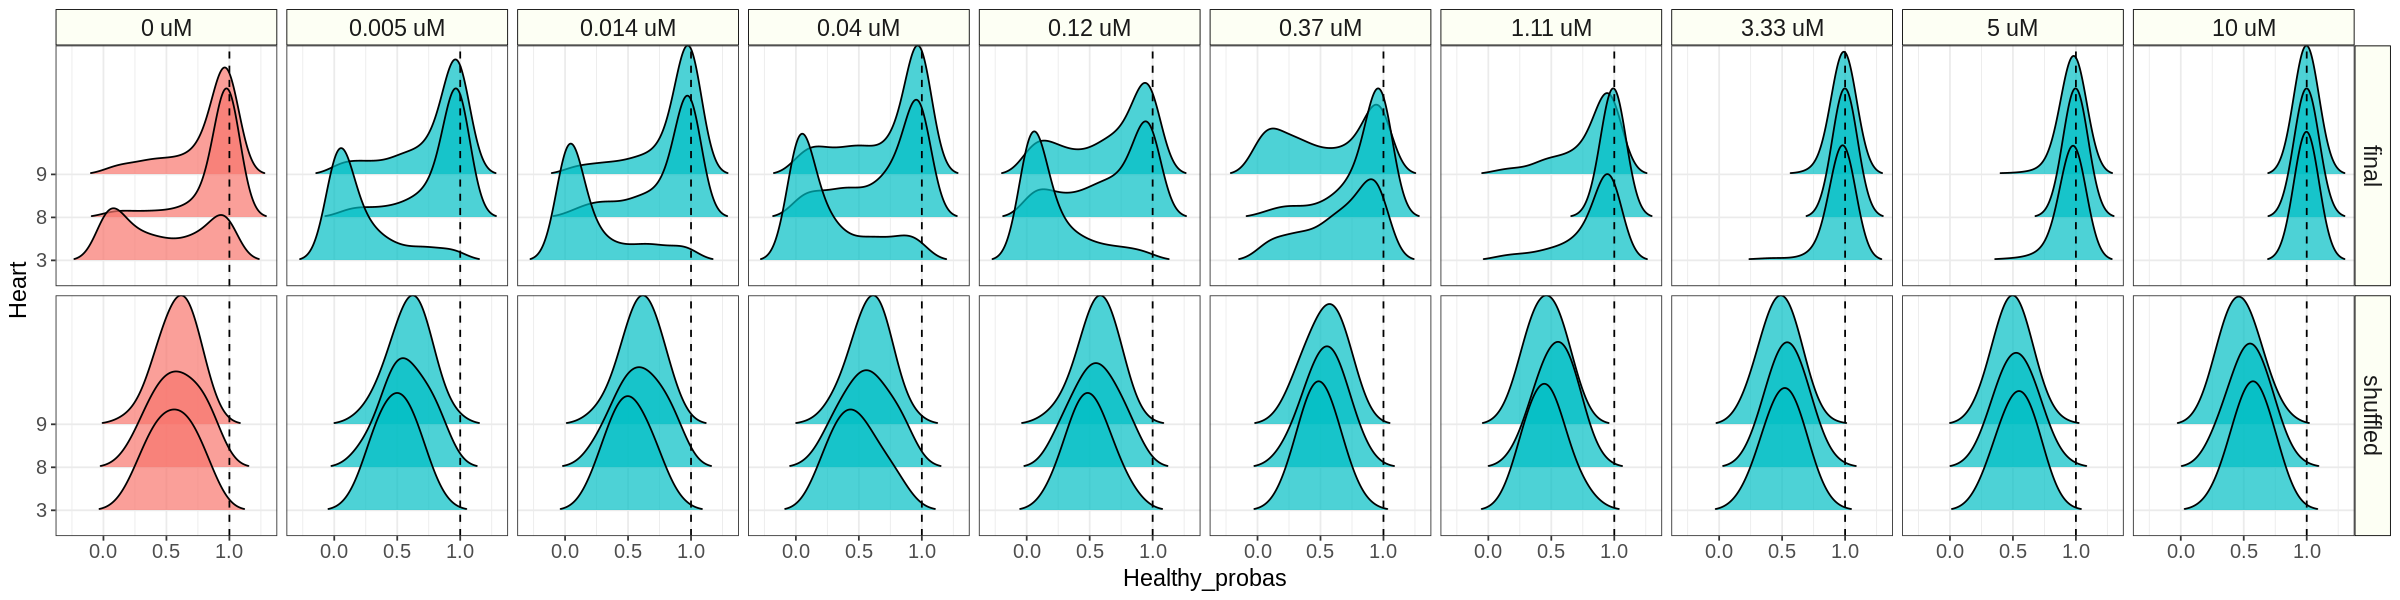

In [4]:
# Add "uM" to all values in the Metadata_dose column
combined_probabilities_df$Metadata_dose <- paste0(combined_probabilities_df$Metadata_dose, " uM")

# Specify the levels in the desired order
dose_levels <- c("0 uM", "0.005 uM", "0.014 uM", "0.04 uM", "0.12 uM", "0.37 uM", "1.11 uM", "3.33 uM", "5 uM", "10 uM")

# Convert Metadata_dose to factor with specified levels
combined_probabilities_df$Metadata_dose <- factor(combined_probabilities_df$Metadata_dose, levels = dose_levels)

height <- 5
width <- 20
options(repr.plot.width = width, repr.plot.height = height)
ridge_plot_healthy <- (
    ggplot(combined_probabilities_df, aes(
        x = Healthy_probas, 
        y = Metadata_heart_number, 
        fill = Metadata_treatment, 
        grouped = Metadata_treatment))
    + geom_density_ridges(
        aes(fill = Metadata_treatment), alpha = 0.7, scale = 3, rel_min_height = 0.01, bandwidth = 0.1
    )
    + geom_vline(xintercept = 1, linetype = "dashed", color = "black")
    + scale_x_continuous(breaks = seq(0, 1, 0.5))
    + facet_grid(model_type ~ Metadata_dose, scales = "free_y")
    + labs(y = "Heart")
    + labs()
    + theme_bw()
    + theme(legend.position = "none",
      axis.text = element_text(size = 12),
      axis.text.x = element_text(size = 12),
      axis.title = element_text(size = 14),
      strip.text = element_text(size = 14),
      strip.background = element_rect(
          colour = "black",
          fill = "#fdfff4"
      )
    )
)

# Save figure
ggsave("./figures/healthy_prob_ridge_plot_plates_1_2.png", ridge_plot_healthy, height = 8, width = 18, dpi = 500)

ridge_plot_healthy


## Visualize counts of predictions across dose

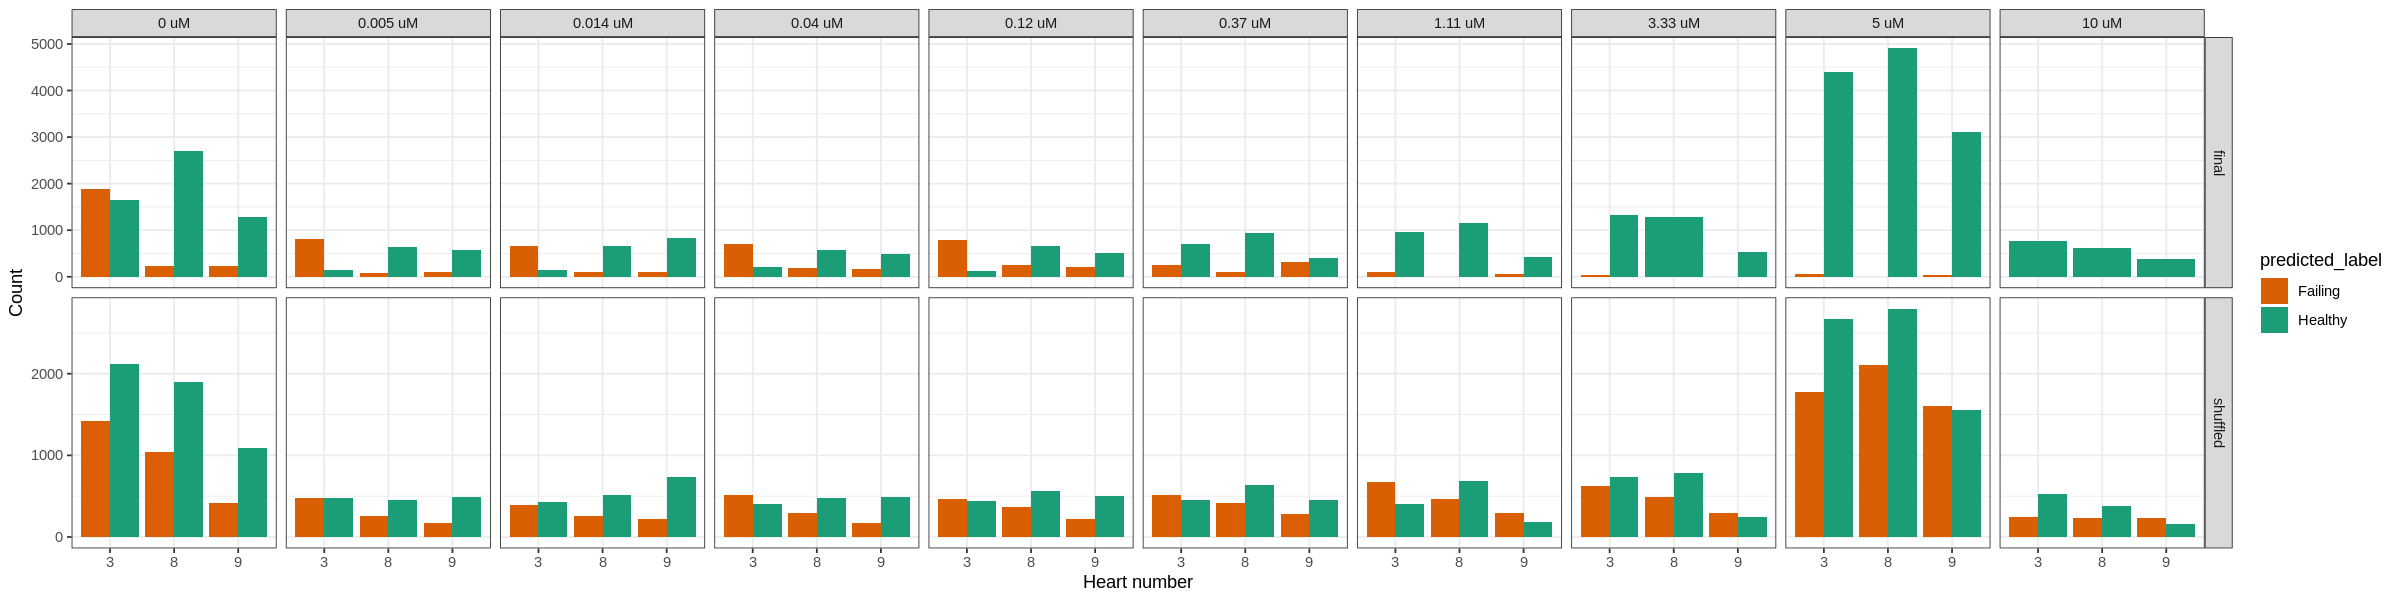

In [5]:
bar_plot_predictions <- (
  ggplot(combined_probabilities_df, aes(x = Metadata_heart_number)) +
  geom_bar(aes(fill = predicted_label), position = "dodge") +
  labs(x = "Heart number", y = "Count")
  + facet_grid(model_type ~ Metadata_dose, scales = "free_y") 
  + scale_fill_manual(values = c(
        "Healthy" = brewer.pal(3, "Dark2")[1],
        "Failing" = brewer.pal(3, "Dark2")[2]
    )) 
  + theme_bw()
)
bar_plot_predictions

## Visualize counts of predictions that are above 0.9 (highly confident) across dose

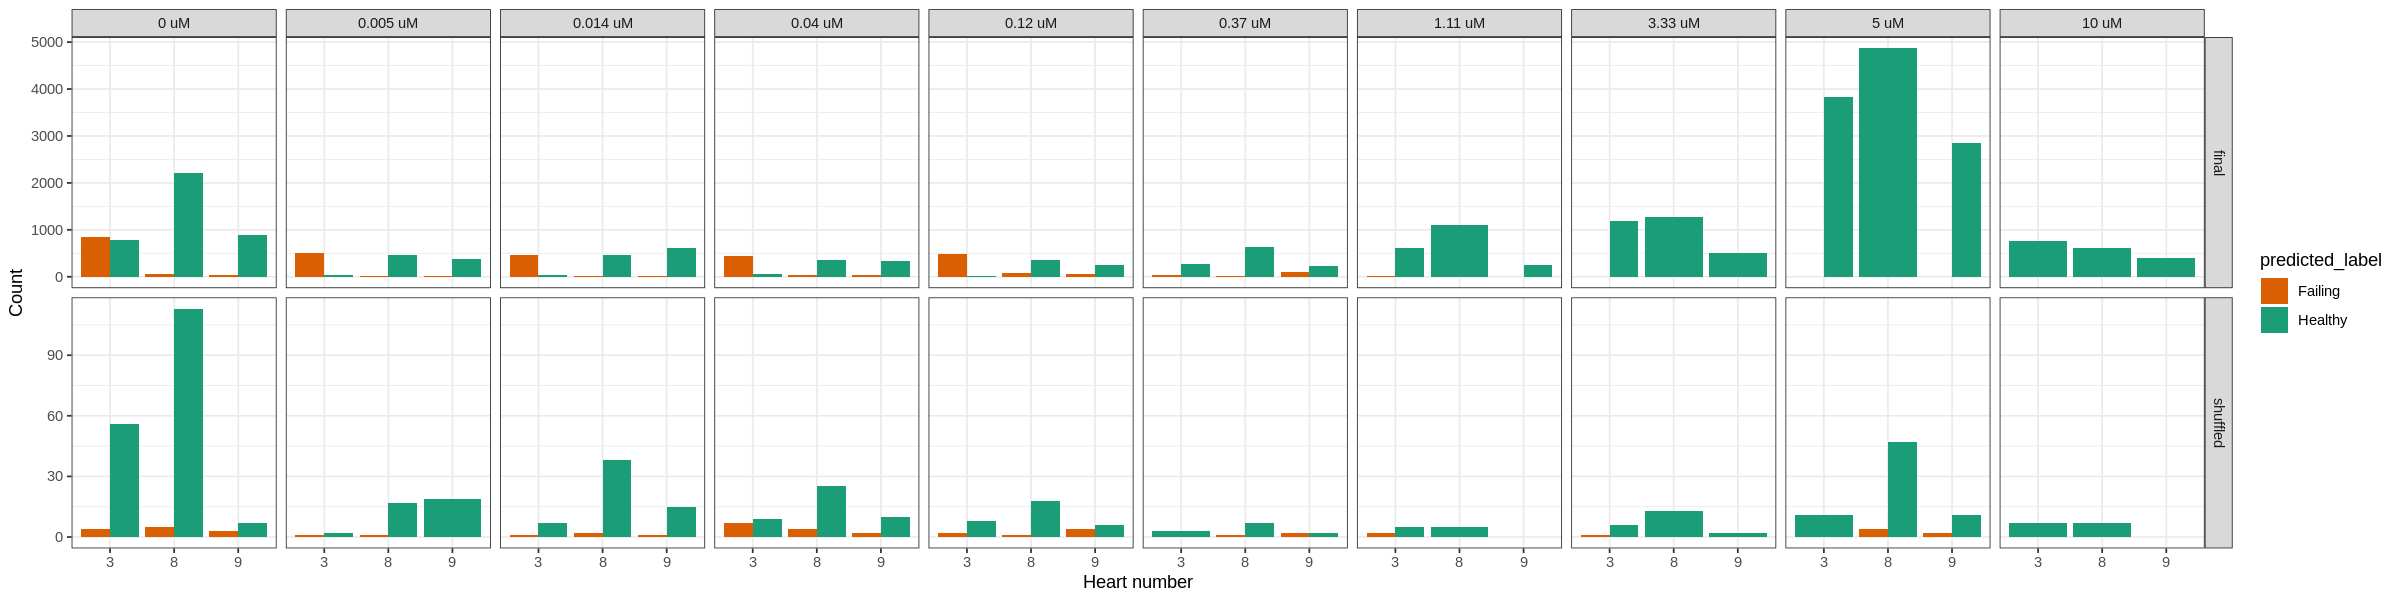

In [6]:
combined_probabilities_df_filtered <- combined_probabilities_df %>%
  filter(Healthy_probas > 0.9 | Failing_probas > 0.9)

bar_plot_predictions_filtered <- (
  ggplot(combined_probabilities_df_filtered, aes(x = Metadata_heart_number))
  + geom_bar(aes(fill = predicted_label), position = "dodge")
  + labs(x = "Heart number", y = "Count")
  + facet_grid(model_type ~ Metadata_dose, scales = "free_y") 
  + scale_fill_manual(values = c(
        "Healthy" = brewer.pal(3, "Dark2")[1],
        "Failing" = brewer.pal(3, "Dark2")[2]
    ))
  + theme_bw()
)

bar_plot_predictions_filtered
